# This notebook will be used to read in the two .nc files containing the Sentinel-1 Gamma0 backscatter, as well as the composite bands created from the backscatter. Using these .nc files, cloud-masked Sentinel-2 images will be retrieved from the GEE. The NDVI and NDWI will be used at 10-meter resolution. Otsu thresholding will be applied on all 9 bands, where the NDVI and NDWI will serve as refinement given the finer spatial resolution.

Probably monthly/seasonal water masks to alleviate cloud-coverage problems as much as possible. Classification will be based on Gamma0_VV, Gamma0_VH, VH/VI, Radar Veg Index, NDVI, and NDWI

In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import os
from osgeo import gdal
import rasterio
import cv2
import ee
import geemap
import geemap.colormaps as cm
import numpy as np
import numpy.ma as ma
from pyproj import Transformer
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
from osgeo import gdal
from skimage.filters import threshold_otsu
import xarray as xr

# Functions

In [146]:
def get_s2_sr_cld_col(aoi, start_date, end_date, cloud_filter):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', cloud_filter)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    combined_coll = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    return combined_coll.map(lambda img: img.clip(aoi))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

def export_image_to_drive(image, description, aoi, resolution):
    """
    Export a single image to Google Drive.

    Args:
        image: ee.Image, the image to be exported.
        description: str, unique description for the export task.
        aoi: ee.Geometry, the area of interest for the export.
    """

    # Setup the export task
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        region=aoi,  # Make sure the geometry (aoi) is defined earlier
        fileFormat='GeoTIFF',
        scale=resolution,  # Adjust the scale as needed,
        maxPixels=1e13
    )
    task.start()
    print(f'Exporting {description} to Drive...')

def get_masked_pixel_percentage(image, region=None, scale=None):
    """
    Computes the percentage of masked pixels for the 'NDVI' and 'NDWI' bands of an ee.Image.
    
    Args:
        image (ee.Image): The image containing the bands 'NDVI' and 'NDWI'.
        region (ee.Geometry, optional): The region over which to compute the statistics.
            Defaults to the image's geometry if not provided.
        scale (number, optional): The scale in meters. Defaults to the image's projection nominal scale.
    
    Returns:
        ee.Dictionary: A dictionary with keys 'NDVI' and 'NDWI' containing the percentage
                       (0-100) of pixels that are masked.
    """
    # Use image geometry and projection if region or scale not provided.
    if region is None:
        region = image.geometry()
    if scale is None:
        scale = image.projection().nominalScale()
    
    def compute_band_percentage(band):
        band_mask = image.select(band).mask().unmask(0)
        
        unmasked_count = ee.Number(
            band_mask.reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=scale,
                maxPixels=1e13
            ).get(band)
        )
        
        total_count = ee.Number(
            ee.Image.constant(1).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=scale,
                maxPixels=1e13
            ).get('constant')
        )
        
        masked_count = total_count.subtract(unmasked_count)
        
        # Return the percentage (0-100) of masked pixels.
        return masked_count.divide(total_count).multiply(100)
    
    # Compute the percentage for each band.
    return ee.Number(compute_band_percentage('NDVI')).getInfo()

In [3]:
def hedley_glint_correction(image, SWIR_band='B11', bands=['B2', 'B3', 'B4', 'B8']):
    # Select bands
    swir = image.select(SWIR_band)
    coefficients = image.select(bands).divide(swir).reduce(ee.Reducer.mean())
    
    # Apply correction
    corrected = image.select(bands).subtract(swir.multiply(coefficients))
    return image.addBands(corrected, overwrite=True).set('glint_corrected', True)

def s2_10m_target_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')

    return image.addBands([ndvi, ndwi])

def otsu_gee(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))  # Correct key
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum_ = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum_.divide(total)

    indices = ee.List.sequence(1, size)

    # Compute between sum of squares (BSS)
    def compute_bss(i):
        i = ee.Number(i)
        a_counts = counts.slice(0, 0, i)
        a_count = a_counts.reduce(ee.Reducer.sum(), [0]).get([0])
        a_means = means.slice(0, 0, i)
        a_mean = a_means.multiply(a_counts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(a_count)

        b_count = total.subtract(a_count)
        b_mean = sum_.subtract(a_count.multiply(a_mean)).divide(b_count)

        return a_count.multiply(a_mean.subtract(mean).pow(2)).add(
            b_count.multiply(b_mean.subtract(mean).pow(2))
        )

    bss = indices.map(compute_bss)

    # Return the mean value corresponding to the maximum BSS
    return means.sort(bss).get([-1])

def extract_valid_bounds_nc_to_epsg4326(nc_file, band_name):
    """Extracts the bounding box of valid (non-NaN) data from a NetCDF file and converts it to EPSG:4326."""
    
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')

    # Ensure the band exists
    if band_name not in dataset.variables:
        raise ValueError(f"Band '{band_name}' not found in the NetCDF file.")

    # Read latitude, longitude, and band data
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    data = dataset.variables[band_name][:]

    # Close the dataset
    dataset.close()

    # Create a mask for valid (non-NaN) pixels
    valid_mask = ~np.isnan(data)

    # Find the row and column indices of valid pixels
    valid_rows, valid_cols = np.where(valid_mask)

    if valid_rows.size == 0 or valid_cols.size == 0:
        raise ValueError("No valid data in the NetCDF file.")

    # Get the lat/lon bounds based on valid data
    min_lat, max_lat = lat[valid_rows.min()], lat[valid_rows.max()]
    min_lon, max_lon = lon[valid_cols.min()], lon[valid_cols.max()]

    # NetCDF usually stores lat/lon as 1D vectors, assuming they are regularly spaced.
    bounds_src_crs = (min_lon, min_lat, max_lon, max_lat)

    # Assuming the NetCDF data is in EPSG:4326, if not, transform to EPSG:4326
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:4326", always_xy=True)
    min_lon_4326, min_lat_4326 = transformer.transform(min_lon, min_lat)
    max_lon_4326, max_lat_4326 = transformer.transform(max_lon, max_lat)

    # Create bounding box in EPSG:4326 format
    bounds_epsg4326 = (min_lon_4326, min_lat_4326, max_lon_4326, max_lat_4326)

    # Convert to Earth Engine Bounding Box
    bbox = ee.Geometry.BBox(bounds_epsg4326[0], bounds_epsg4326[1], bounds_epsg4326[2], bounds_epsg4326[3])

    return bbox

def get_date(image):
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

def mosaic_images_for_date(date, sentinel2_col):
    date_filter = ee.Filter.date(date, ee.Date(date).advance(1, 'day'))

    # Try to get Sentinel-2 mosaic; return None if no images available
    s2_filtered = sentinel2_col.filter(date_filter)
    s2_mosaic = ee.Algorithms.If(s2_filtered.size().gt(0), s2_filtered.mosaic(), None)
    
    return ee.Dictionary({
        'date': date,
        'S2': s2_mosaic
    })

## Function to add spectral indices images to the map.
def add_ind_to_map(image, map_object, band, date):

    if band =='NDWI':
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.ndwi}, f'{date}_{band}')
    elif band =='NDVI': 
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.ndvi}, f'{date}_{band}')

def filter_images_by_valid_pixels(mosaic_dict, subset_aoi, percentage, im_scale):
    good_ims = {}
    
    for date in list(mosaic_dict.keys()):
        image = ee.Image(mosaic_dict[date].get('S2'))
        valid_pixels = image.mask().reduceRegion(
                        reducer=ee.Reducer.sum(),
                        geometry=subset_aoi,
                        scale=im_scale,
                        maxPixels=1e13
                    ).values().get(0)
        total_pixels = subset_aoi.area().divide(im_scale ** 2)  # Estimate total pixels at given scale
        valid_fraction = ee.Number(valid_pixels).divide(total_pixels)

        if valid_fraction.getInfo() > percentage:
            good_ims[date] = image

    return good_ims

def visualize_nc_band(nc_file, band_name):
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')
    
    # Check if the band exists
    if band_name not in dataset.variables:
        print(f"Error: Band '{band_name}' not found in the NetCDF file.")
        print("Available bands:", list(dataset.variables.keys()))
        dataset.close()
        return

    # Extract latitude, longitude, and the requested band
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    band_data = dataset.variables[band_name][:]

    # Close the dataset after reading
    dataset.close()

    # Handle missing values (replace with NaN)
    band_data = np.where(np.isnan(band_data), np.nanmin(band_data), band_data)

    # Clip values to avoid extreme outliers
    vmin, vmax = np.percentile(band_data, [1, 99])

    # Plot the specified band with enhanced visualization
    plt.figure(figsize=(8, 6))
    plt.imshow(band_data, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label=band_name)
    plt.title(f'{band_name} Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # plt.grid(True)
    plt.show()

def check_spatial_resolution(nc_file):
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')

    # Extract latitude and longitude
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]

    # Close the dataset
    dataset.close()

    # Calculate the resolution by taking the mean difference
    lat_res = np.abs(lat[1] - lat[0])  # Latitude resolution
    lon_res = np.abs(lon[1] - lon[0])  # Longitude resolution

    print(f"Latitude resolution: {lat_res:.6f} degrees")
    print(f"Longitude resolution: {lon_res:.6f} degrees")

    # Approximate resolution in meters (assuming 1 degree ≈ 111 km)
    lat_res_m = lat_res * 111000
    lon_res_m = lon_res * 111000 * np.cos(np.deg2rad(lat.mean()))

    print(f"Approximate pixel size: {lat_res_m:.2f} meters (latitude), {lon_res_m:.2f} meters (longitude)")

def otsu_nc(nc_path):
    ds = xr.open_dataset(nc_path)
    
    thresholds = {}
    
    for band in ds.data_vars.keys():  # Loop through each band
        data = ds[band].values  # Extract NumPy array
        
        # Ensure data is valid (no NaNs)
        data = np.nan_to_num(data, nan=0)
        
        if data.ndim == 2:  # Single-band case
            thresholds[band] = threshold_otsu(data)
        
        elif data.ndim == 3:  # Multi-band case (e.g., [time, height, width])
            thresholds[band] = [threshold_otsu(data[i]) for i in range(data.shape[0])]

    ds.close()
    return thresholds

def normalize(img):
    """ Normalize an image for better visualization """
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [5]:
ee.Initialize(project='ee-claycaldgsl')

# 1. Read in the custom Gamma0 .nc files

In [60]:
PROJECT = 'SabineRS'
SYSTEM = 'mac'          # or 'linux'


if SYSTEM == 'linux':
    grd_dir = f'/home/clay/Documents/{PROJECT}/Sentinel-1/GRD/ASCENDING/136/93/10_netcdfs'
    comp_dir =f'/home/clay/Documents/{PROJECT}/Sentinel-1/GRD/ASCENDING/136/93/11_composites'
else:
    grd_dir = f'/Users/clayc/Documents/Work/{PROJECT}/Sentinel-1/GRD/ASCENDING/136/93/10_netcdfs'
    comp_dir =f'/Users/clayc/Documents/Work/{PROJECT}/Sentinel-1/GRD/ASCENDING/136/93/11_composites'

if os.path.exists(grd_dir) == False:
    aoi = ee.Geometry.BBox(-93.68183131860044, 30.403070192729114, -92.57492722550838, 29.476368145631415)

else:
    nc_files = {}
    
    grd_dates = sorted(file[:-3] for file in os.listdir(grd_dir) if file.endswith('.nc')) 
    grd_dates = [datetime.strptime(key, "%Y%m%d") for key in grd_dates]
    grd_files = sorted([os.path.join(grd_dir, f'{file}') for file in os.listdir(grd_dir) if file.endswith('.nc')]) 
    comp_files = sorted([os.path.join(comp_dir, f'{file}') for file in os.listdir(comp_dir) if file.endswith('.nc')]) 
    
    for i, date in enumerate(grd_dates):
        nc_files[date] = [grd_files[i], comp_files[i]]
    
    aoi = extract_valid_bounds_nc_to_epsg4326(grd_files[0], 'Gamma0_VV')

In [ ]:
# visualize_nc_file(grd_files[-1])
# check_spatial_resolution(grd_files[-1])

# Sentinel-2 segmentation 
- reference Landyut et al 2020. This paper had an interesting approach to unsupervised water masking that could also be applied for my wetlands BUDM research

Meanshift or similar moving window density based approach initially. Include additional features from freely available data (LULC?, Sentinel-2 bands, up-to-date DEMs) to improve the feature space for feature extraction. Fuzzy C-means or similar with Otsu based refinement? Then a similar region growing-decaying method for the final map?

Landyut et al 2020 utilized pairs to create the individual flood maps. Maybe I will implement a similar approach, though it would reduce the observations from an at-epoch basis to between-epoch basis. Could effectively reduce the number of 

- Otsu on all 20-meter SAR bands
- Otsu on NDVI and NDWI 10-meter bands
- Majority voting with SAR, refinement with NDVI and NDWI
- Final shoul give water mask for each registered pair

- HDBSCAN initial clustering to create objects, hopefully it identifies the BUDM sites easily
- Backscatter based refinement
- Extract feature space similar to that of Landyut, may leave out the DEM part as this could be included in InSAR? Maybe also leaving out Land Cover
- Fuzzy C-Means clustering of the feature space into three classes; Land, Transition, and Open Water
- Refine the Transition class somehow, maybe using Otsu to separate into Land and Open water?

1. Discrete Wavelength Transforms on Gamma0 backscatter bands (VV and VH)
2. Fuzzy C-Means on the DWT products, n=3
3. Minimum Entropy and/or Fuzzy Maximum Aggregatiom
4. Bring in VH/VV, NDPI, NVVI, NVHI, and RVI from S1; RGB, NIR, NDVI, NDWI from S2
5. Ensemble Otsu or Another Unsupervised Clusterer
6. Morphological functions for refinement

In [92]:
grd_groups = {}
for dt, images in nc_files.items():
    key = dt.strftime('%Y-%m')
    grd_groups.setdefault(key, []).append(images[0])

comp_groups = {}
for dt, images in nc_files.items():
    key = dt.strftime('%Y-%m')
    comp_groups.setdefault(key, []).append(images[1])

In [94]:
grd_monthlies = {}                  # first array is VV, second array is VH

for dt, pairs in grd_groups.items():
    for im in pairs:
        with nc.Dataset(im, mode='r') as ds:
            bands_data = []
            for band in ['Gamma0_VV', 'Gamma0_VH']:
                data = ds.variables[band][:]
                # Replace NaNs with the minimum non-NaN value
                min_val = np.nanmin(data)
                data = np.where(np.isnan(data), min_val, data)
                # Clip extreme values (1st and 99th percentile)
                vmin, vmax = np.percentile(data, [1, 99])
                # data = np.clip(data, vmin, vmax)
                # Normalize to 0-255
                norm_data = ((data - vmin) / (vmax - vmin)) * 255
                bands_data.append(norm_data.astype(np.uint8))
        median_array = np.median(np.stack(bands_data), axis=0)
        grd_monthlies.setdefault(dt, []).append(median_array)

In [95]:
comp_monthlies = {}                  # first array is VV, second array is VH

for dt, pairs in comp_groups.items():
    for im in pairs:
        with nc.Dataset(im, mode='r') as ds:
            bands_data = []
            for band in ['VH_VV', 'RVI']:
                data = ds.variables[band][:]
                # Replace NaNs with the minimum non-NaN value
                min_val = np.nanmin(data)
                data = np.where(np.isnan(data), min_val, data)
                # Clip extreme values (1st and 99th percentile)
                vmin, vmax = np.percentile(data, [1, 99])
                # data = np.clip(data, vmin, vmax)
                # Normalize to 0-255
                norm_data = ((data - vmin) / (vmax - vmin)) * 255
                bands_data.append(norm_data.astype(np.uint8))
        median_array = np.median(np.stack(bands_data), axis=0)
        comp_monthlies.setdefault(dt, []).append(median_array)

In [96]:
# Compute the smallest shape by finding the minimum height and width
min_h = min(ar.shape[0] for ims in grd_monthlies.values() for ar in ims)
min_w = min(ar.shape[1] for ims in grd_monthlies.values() for ar in ims)
min_shape = (min_h, min_w)
print("Smallest array shape:", min_shape)

# Crop all arrays in grd_monthlies to the smallest shape
for date in list(grd_monthlies.keys()):
    grd_monthlies[date] = [ar[:min_h, :min_w] for ar in grd_monthlies[date]]
    comp_monthlies[date] = [ar[:min_h, :min_w] for ar in comp_monthlies[date]]


Smallest array shape: (5140, 6095)


1. DWT

In [97]:
test1 = grd_monthlies['2019-10'][0]
test2 = grd_monthlies['2019-10'][1]

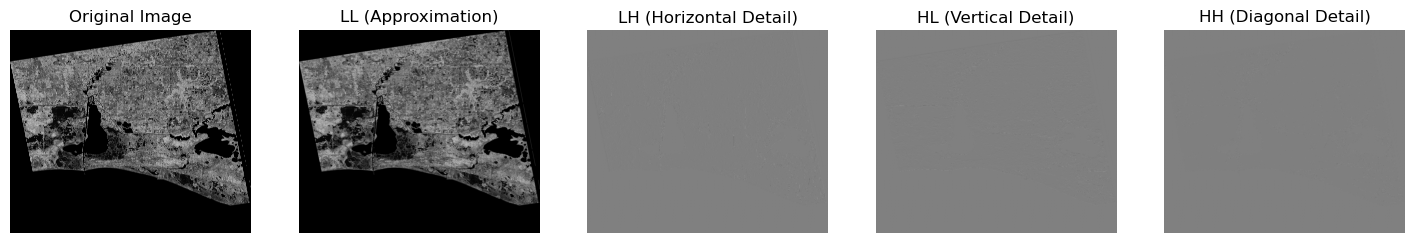

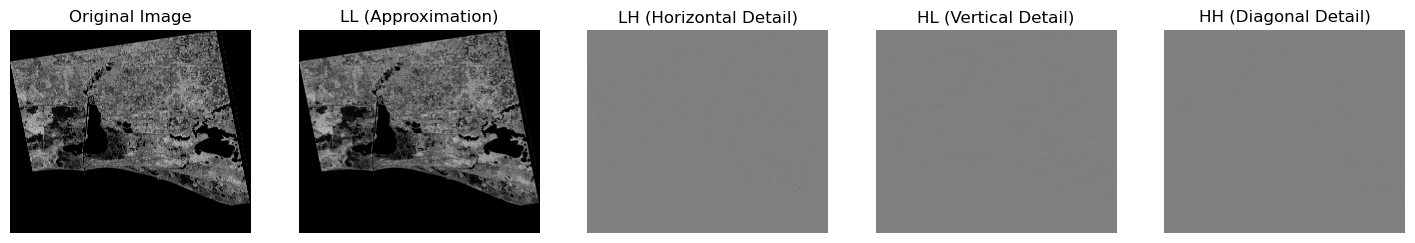

In [98]:
import pywt

# Apply DWT without restriction on even dimensions
wavelet = 'haar'  # You can change this to 'db2', 'coif1', etc.
dwtbands = []
for im in [test1, test2]:


    coeffs = pywt.dwtn(im, wavelet)

    # Extract sub-bands
    LL = coeffs['aa']  # Approximation (Low-Low)
    LH = coeffs['ad']  # Horizontal detail (Low-High)
    HL = coeffs['da']  # Vertical detail (High-Low)
    HH = coeffs['dd']  # Diagonal detail (High-High)


    # Normalize each detail sub-band
    LH_norm = normalize(LH)
    HL_norm = normalize(HL)
    HH_norm = normalize(HH)

    for band in [LL, LH_norm, HL_norm, HH_norm]:
        dwtbands.append(band)

    # Display results
    fig, axes = plt.subplots(1, 5, figsize=(18, 5))

    axes[0].imshow(im, cmap='gray')
    axes[0].set_title("Original Image")

    axes[1].imshow(LL, cmap='gray')
    axes[1].set_title("LL (Approximation)")

    axes[2].imshow(LH_norm, cmap='gray')
    axes[2].set_title("LH (Horizontal Detail)")

    axes[3].imshow(HL_norm, cmap='gray')
    axes[3].set_title("HL (Vertical Detail)")

    axes[4].imshow(HH_norm, cmap='gray')
    axes[4].set_title("HH (Diagonal Detail)")

    for ax in axes:
        ax.axis("off")

    plt.show()

2. Fuzzy C-Means on DWT products from Gamma0_VV and Gamma0_VH

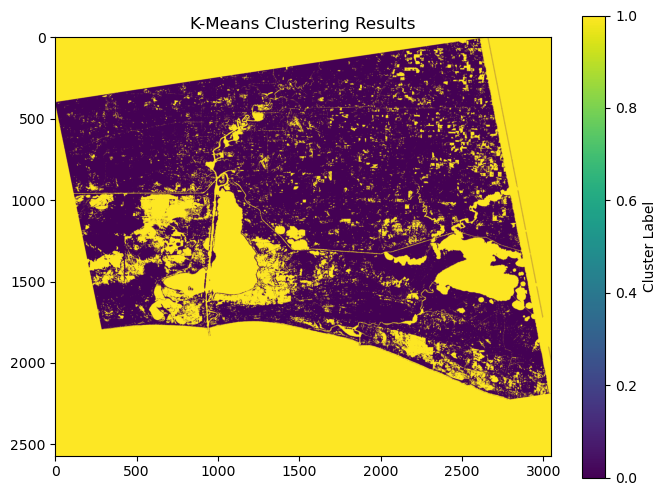

In [151]:
from sklearn.cluster import KMeans

# Stack the four bands into an array with shape (height, width, 8)
stacked = np.stack(dwtbands, axis=2)

# Reshape the stacked array to have shape (number_of_pixels, features)
X = stacked.reshape(-1, stacked.shape[2])

# Perform K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Reshape cluster labels back to image dimensions
cluster_map = kmeans.labels_.reshape(stacked.shape[0], stacked.shape[1])

# Display the clustering result
plt.figure(figsize=(8, 6))
plt.imshow(cluster_map, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.title('K-Means Clustering Results')
plt.show()


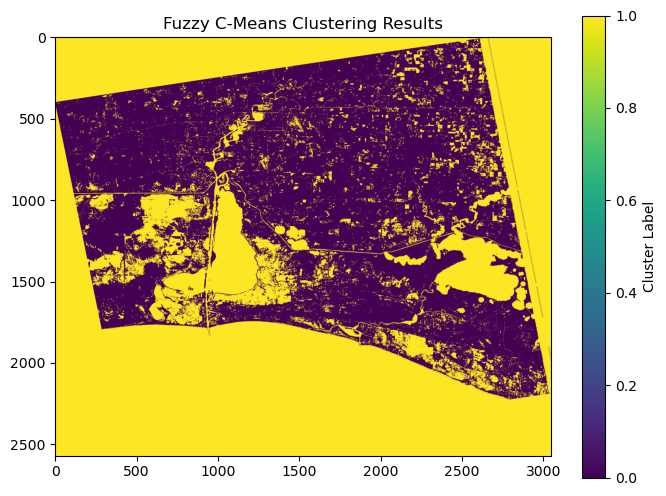

In [148]:
import skfuzzy as fuzz


# Stack the four bands into an array with shape (height, width, 8)
stacked = np.stack(dwtbands, axis=2)

# Reshape the stacked array to have shape (features, number_of_pixels)
X = stacked.reshape(-1, len(dwtbands)).T

# Perform Fuzzy C-Means clustering with 3 clusters
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X, c=2, m=2, error=0.005, maxiter=1000, init=None
)

# Get cluster labels (the membership highest for each pixel)
cluster_labels = np.argmax(u, axis=0)

# Reshape cluster labels back to image dimensions
cluster_map = cluster_labels.reshape(stacked.shape[0], stacked.shape[1])

# Display the clustering result
plt.figure(figsize=(8, 6))
plt.imshow(cluster_map, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.title('Fuzzy C-Means Clustering Results')
plt.show()

3. Bring in VH/VI, Radar Veg Index from Sentinel-1; NDVI and NDWI from Sentinel-2.

- Otsu each band
- Ensemble voting with FCM classes and 4 otsu for final water mask?

In [116]:
test2 = []

for band in comp_monthlies[date]:
    # Convert the image to 8-bit unsigned integer
    band_uint8 = band.astype(np.uint8)
    # Apply OpenCV's Otsu Thresholding
    _, binary_mask = cv2.threshold(band_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Convert binary mask values from 255 to 1 if needed
    binary_mask = binary_mask.astype(np.uint8) // 255
    test2.append(binary_mask)

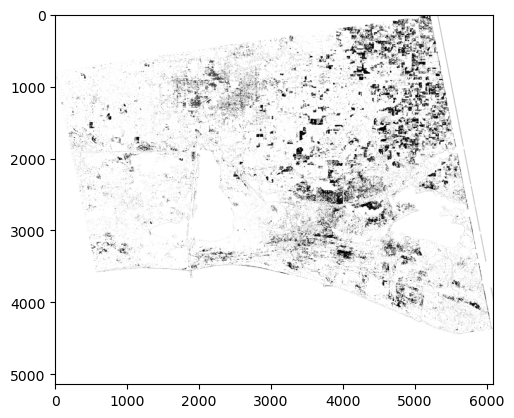

In [160]:
# Stack masks and apply majority voting (if bands exist)
# Resize cluster_map to match the dimensions of test2 arrays before stacking
resized_cluster_map = cv2.resize(cluster_map.astype(np.uint8),
                                 (test2[0].shape[1], test2[0].shape[0]),
                                 interpolation=cv2.INTER_NEAREST)

binary_masks = np.stack([resized_cluster_map, test2[0]], axis=0)  # Shape: (N_bands, H, W)
final_s1_mask = np.mean(binary_masks, axis=0) >= 0.5  # Majority vote: at least 50%
plt.imshow((final_s1_mask), cmap='gray')

In [ ]:
otsu_masks = {}

for entry in list(nc_files.items()):
    maskedbands = []
    date = entry[0]
    files = [entry[1][0], entry[1][1]]
    file_bands = [['Gamma0_VV', 'Gamma0_VH'], ['VH_VV', 'NDPI', 'NVVI', 'NVHI', 'RVI']]

    for file, bands in zip(files, file_bands):
        for band in bands:
            dataset = nc.Dataset(file, mode='r')

            if band not in dataset.variables:
                print(f"Error: Band '{band}' not found in the NetCDF file.")
                print("Available bands:", list(dataset.variables.keys()))
                dataset.close()
                continue  # Move to the next band

            # Extract latitude, longitude, and the requested band
            lat = dataset.variables['lat'][:]
            lon = dataset.variables['lon'][:]
            band_data = dataset.variables[band][:]

            # Close the dataset after reading
            dataset.close()

            # Handle missing values (replace NaN with min value)
            band_data = np.where(np.isnan(band_data), np.nanmin(band_data), band_data)

            # Clip extreme values (1st to 99th percentile)
            vmin, vmax = np.percentile(band_data, [1, 99])
            clipped_data = np.clip(band_data, vmin, vmax)

            # Normalize to 0-255 and convert to uint8 (for OpenCV)
            norm_data = ((clipped_data - vmin) / (vmax - vmin)) * 255
            norm_data_uint8 = norm_data.astype(np.uint8)

            # Apply OpenCV's Otsu Thresholding
            _, binary_mask = cv2.threshold(norm_data_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Convert binary mask to 0-1 and handle NaNs
            binary_mask = binary_mask.astype(np.uint8) // 255  # Convert from 255 (OpenCV) to 1
            binary_mask[np.isnan(band_data)] = 0  # Keep original NaNs as 0

            maskedbands.append(binary_mask)
            

        # # Stack masks and apply majority voting (if bands exist)
        # if maskedbands:
        #     binary_masks = np.stack(maskedbands, axis=0)  # Shape: (N_bands, H, W)
        #     final_s1_mask = np.mean(binary_masks, axis=0) >= 0.5  # Majority vote: at least 50%

        #     otsu_masks[date] = final_s1_mask


4. Morpho functions for refinement?

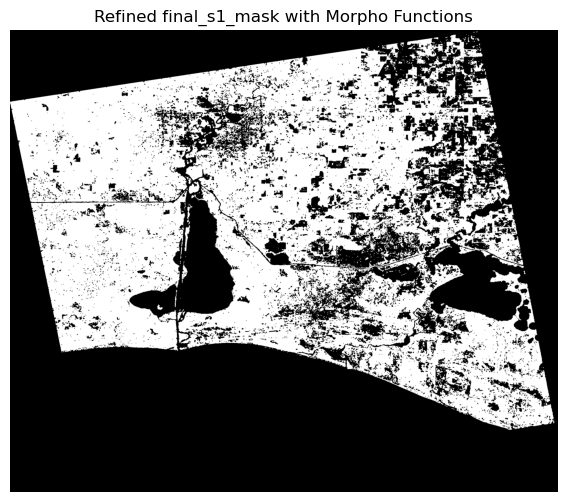

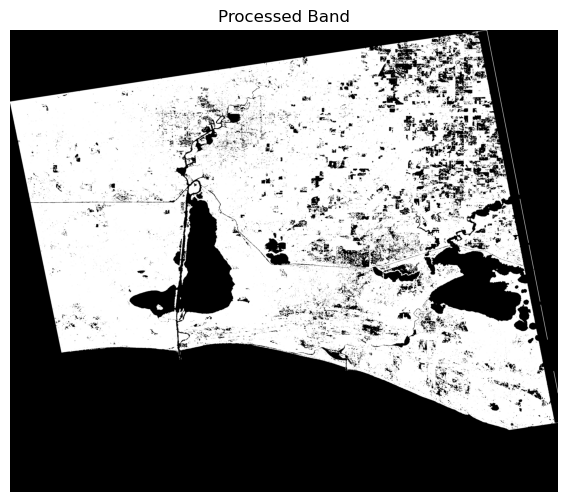

In [130]:
# Convert the final_s1_mask (a boolean array) to uint8 (0 and 255)
mask_uint8 = final_s1_mask.astype(np.uint8) * 255

# Define a structuring element (kernel)
kernel = np.ones((5, 5), np.uint8)

# Apply an opening (erosion followed by dilation) to remove small noise
morph_open = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel)

# Apply a closing (dilation followed by erosion) to fill small holes
morph_closed = cv2.morphologyEx(morph_open, cv2.MORPH_CLOSE, kernel)

# Display the refined mask
plt.figure(figsize=(8,6))
plt.imshow(morph_closed, cmap='gray')
plt.title("Refined final_s1_mask with Morpho Functions")
plt.axis("off")
plt.show()

# Process a band image further.
# Replace 'band' with your desired image array; here we use "final_s1_mask"
band = final_s1_mask.copy()

# Convert the boolean mask to uint8 (0 and 255)
band = band.astype(np.uint8) * 255

# Now normalize and process:
band = cv2.normalize(band, None, 0, 255, cv2.NORM_MINMAX)
band = cv2.medianBlur(band, 3)
band = cv2.GaussianBlur(band, (3, 3), 0)
band = cv2.convertScaleAbs(band)
band = cv2.threshold(band, 0, 255, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(8, 6))
plt.imshow(band, cmap='gray')
plt.title("Processed Band")
plt.axis("off")
plt.show()

# Retrieve Sentinel-2 imagery from GEE
- All bands?
- All 10-meter bands?

In [131]:
s2_cloud_cov = 20
START_DATE = '2019-10-01'
END_DATE = '2019-11-01'
CLD_PRB_THRESH = 35
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 100
ORBIT = 'ASCENDING'

s2_coll = get_s2_sr_cld_col(aoi, START_DATE, END_DATE, s2_cloud_cov)

s2_cm = (s2_coll.map(add_cld_shdw_mask).map(apply_cld_shdw_mask).map(s2_10m_target_indices)).select(['NDVI', 'NDWI'])       # cloud masked sentinel-2 10-meter ndvi and ndwi bands

Mosaic images with matching dates
- Common cells for GEE Sentinel imagery typically smaller than that of ASF/Copernicus
- Could result in multiple images for a single day
- Iterate through the information or each of the images in the S1 and S2 collections, mosaic matching dates.

In [132]:
s2_date_list = s2_cm.map(get_date).aggregate_array('date').getInfo()
unique_list = sorted(list(set(s2_date_list)))

In [134]:
# Create a dictionary of mosaicked images for all dates
mosaic_dict = {}
for date in unique_list:
    mosaics = mosaic_images_for_date(date, s2_cm)
    strpdate = datetime.strptime(date, '%Y-%m-%d')
    mosaic_dict[strpdate] = mosaics

In [141]:
# Extract the S2 images from each ee.Dictionary in mosaic_dict
s2_images = [mosaic_dict[dt].get('S2') for dt in mosaic_dict]

# Construct an ImageCollection and compute its median
median_image = ee.ImageCollection(s2_images).median()

# (Optional) Examine the result
print(median_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'NDVI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'NDWI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [142]:
maptest = geemap.Map()
maptest.centerObject(aoi, 12)

# Define visualization parameters for the median image
median_vis_params = {"bands": ["NDVI"], "min": -1, "max": 1}

# Add the median image layer to the map
maptest.addLayer(median_image, median_vis_params, "Median Sentinel-2 Image")

# Display the map with a layer control
maptest.addLayerControl(position='topright')
maptest


Map(center=[29.939385132625254, -93.12837927205447], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
export_image_to_drive(median_image, '2019-10_median', aoi, 20)

Exporting 2019-10_median to Drive...


In [152]:
# import the .tif files and temporally register the images with one another
with rasterio.open(f'/Users/clayc/Documents/Work/{PROJECT}/Sentinel-2/2019-10_median.tif') as src:
    s2_image = src.read()
    s2_meta = src.meta
    s2_meta.update({'height': s2_image.shape[1], 'width': s2_image.shape[2]})
    print(s2_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 6162, 'height': 5159, 'count': 2, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0001796630568239043, 0.0, -93.68188738274524,
       0.0, -0.0001796630568239043, 30.403121464911557)}


In [156]:
s2_image_cropped.shape

(2, 5140, 6095)

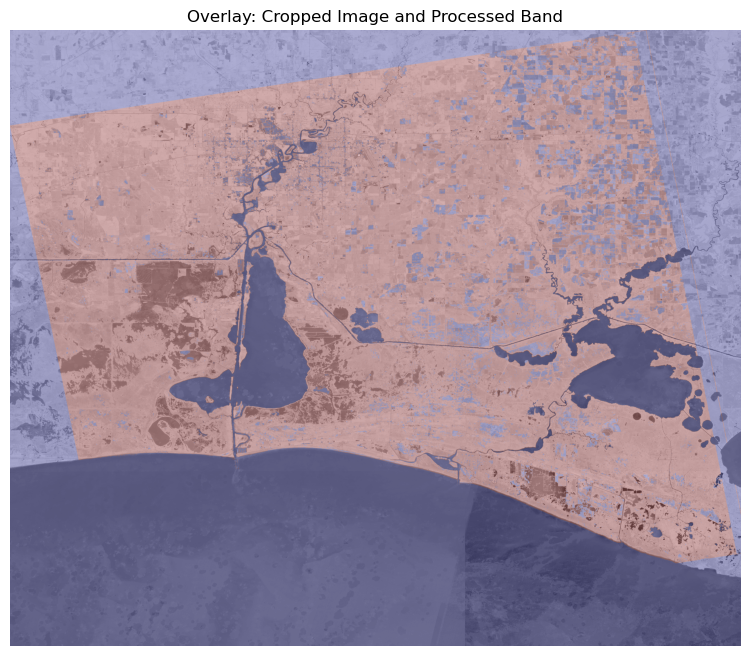

In [159]:
plt.figure(figsize=(12, 8))
plt.imshow(s2_image[0], cmap='gray', alpha=0.7)
plt.imshow(band, cmap='jet', alpha=0.3)
plt.title('Overlay: Cropped Image and Processed Band')
plt.axis('off')
plt.show()

In [ ]:
ndvi_ims = {}
ndwi_ims = {}

for band in ['NDVI', 'NDWI']:
    for date in nc_files.keys():
        if len(nc_files[date]) == 3:
            image = ee.Image(nc_files[date][-1].get('S2'))
            histogram = image.select(band).reduceRegion(
            reducer=ee.Reducer.histogram(),
            geometry=aoi,
            scale=10,  # Adjust based on your dataset resolution
            maxPixels=1e15
            ).get(band)

            result = otsu_gee(histogram)
            threshold = result.getInfo()

            # Create binary mask
            binary_mask = image.select(band).gt(threshold)
        
        if band == 'NDVI':
            ndvi_ims[date] = binary_mask
        else:
            ndwi_ims[date] = binary_mask

In [ ]:
# FOR NDVI AND NDWI REFINEMENT LATER

# Compute Otsu’s thresholds
ndwi_otsu = threshold_otsu(ndwi)
ndvi_otsu = threshold_otsu(ndvi)

# Constrain to literature-based values
ndwi_thresh = max(ndwi_otsu, 0.1)  # Prevent overly strict thresholds
ndvi_thresh = min(ndvi_otsu, 0.3)  # Prevent excessive masking

# Apply refined thresholds
ndwi_mask = ndwi > ndwi_thresh
ndvi_mask = ndvi < ndvi_thresh

# Combine with Sentinel-1 water mask
final_mask = water_mask & ndwi_mask & ndvi_mask
